In [1]:
import sumie
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

%load_ext autoreload

%autoreload 2

In [2]:
model = torchvision.models.vgg16(pretrained=True).eval()
sumie.utils.remove_inplace(model)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pad

  0%|          | 0/1000 [00:00<?, ?it/s]/data/home/justin/code/sumie/venv/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
100%|██████████| 1000/1000 [02:09<00:00,  7.47it/s]


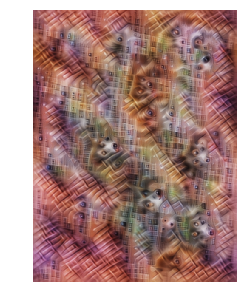

In [3]:
class ProgressiveShift(torch.nn.Module):

    def __init__(self):
        super(ProgressiveShift, self).__init__()
        self.amount = 0
        
    def forward(self, image):
        self.amount += 1
        return image.roll(self.amount, 2)

class Composite():

    def __init__(self, children, weights):
        self.children = children
        self.weights = weights
        
    @property
    def objective(self):
        total = 0
        for child, weight in zip(self.children, self.weights):
            total += weight*child.objective
        return total


def scale_image(i, image, model, objective, opt):
    if i % 2 == 0:
        scaled = torch.nn.functional.interpolate(image.base_image.pixels.data, scale_factor=1.005, mode='bilinear', align_corners=False)
        original_size = image.base_image.pixels.data.size()
        image.base_image.pixels.data = scaled[:original_size[0],:original_size[1],:original_size[2],:original_size[3]]

def grab_value(a):
    return a[5, 5]
        
def change_objective(i, image, model, objective, opt):
    if i % 100 == 0:
        opt.objective = sumie.objectives.ConvChannel(model[26], np.random.randint(512), func=torch.std)

def change_combined(i, image, model, objective, opt):
    if i % 100 == 0:
        opt.objective.children[0] = sumie.objectives.ConvChannel(model[26], np.random.randint(512))
    if i % 75 == 0:
        opt.objective.children[1] = sumie.objectives.ConvChannel(model[10], np.random.randint(256), func=torch.std)
        
im = sumie.Image((480, 640), param='fft', transforms=[
                    sumie.transforms.PositionJitter(8),
                    sumie.transforms.Interpolate(0.5),
                    sumie.transforms.ScaleJitter(1.1),
                    sumie.transforms.Normalise(),
              ]
            )

device = 'cuda'
im.to(device)
model.to(device)
opt = sumie.Optimiser()
opt.add_callback(change_combined)
channel = sumie.objectives.ConvChannel(model.features[26], 0, func=grab_value)
obj2 = sumie.objectives.ConvChannel(model.features[10], 0, func=torch.std)
combined = Composite([channel, obj2], [1, 7.5])

opt.run(im, model.features, combined, iterations=1000, progress=True, lr=0.025, output='tmp')
sumie.vis.show(im.get_image())

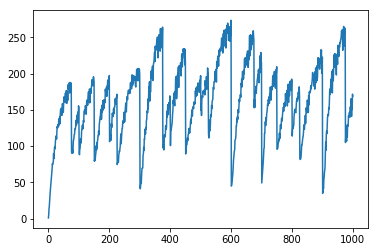

In [4]:
plt.plot([x.item() for x in opt.history])

In [5]:
for child in opt.objective.children:
    print(child.objective)


tensor(39.1033, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(17.3056, device='cuda:0', grad_fn=<StdBackward0>)


NameError: name 'animation' is not defined

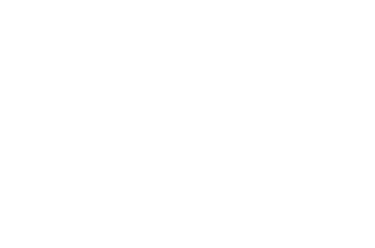

In [6]:
def to_frame(i):
  return animation[i,:,:,:].squeeze(0).permute((1, 2, 0)).numpy()

fig = plt.figure()
ax = plt.axes(xlim=(0, 224), ylim=(0, 224))
plt.axis('off')
ax.grid(False)
im=plt.imshow(to_frame(0))

# initialization function: plot the background of each frame
def init():
    im.set_data(to_frame(0))
    return [im]

# animation function.  This is called sequentially
def animate(i):
  if i<100:
    im.set_array(to_frame(i))
  else:
    im.set_array(to_frame(199-i))
  return [im]
  
anim = matplotlib.animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, 
                               blit=True, repeat=True)
#HTML(anim.to_jshtml())

In [ ]:
HTML(anim.to_html5_video())